# Frontal Detection Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime # need cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [169]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37556 instead
  warnings.warn(


In [170]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/37556/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/37556/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:45025,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/37556/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Close cluster/client as needed
Do I need both these commands?

In [177]:
cluster.close()
#client.close()

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/k

### Set fronts filepath

In [4]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

## CESM historical/RCP2.6 simulation, 2000-2015

In [5]:
#onehot_file = "cesm_frontsOneHot_2000-2005.nc"
onehot_file = "cesm_frontsOneHot_2000-2015.nc"

In [6]:
onehot = xr.open_dataset(cesm_fronts_filepath+onehot_file, chunks={'time':360}) # aim for chunk size < 100mb

In [7]:
fronts = onehot.fronts
fronts
#fronts.front

<xarray.DataArray 'fronts' (time: 46720, front: 5, lat: 68, lon: 141)>
dask.array<open_dataset-1542549fcfe121d3a5415764d338270afronts, shape=(46720, 5, 68, 141), dtype=float32, chunksize=(360, 5, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
  * lat         (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
  * lon         (lon) float64 189.0 190.0 191.0 192.0 ... 327.0 328.0 329.0
    front_type  (front) object dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: front
Attributes:
    long_name:     one-hot predicted fronts
    grid_mapping:  crs
    valid_min:     0
    valid_max:     1

Extract most likely front from onehot (via argmax)

In [8]:
%%time
allfronts = fronts.argmax(dim='front')

CPU times: user 1.98 ms, sys: 0 ns, total: 1.98 ms
Wall time: 1.99 ms


In [9]:
allfronts

<xarray.DataArray 'fronts' (time: 46720, lat: 68, lon: 141)>
dask.array<nanarg_agg-aggregate, shape=(46720, 68, 141), dtype=int64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0

### Read in precipitation field

In [10]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output
cesm_rcp26_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/" # RCP2.6 output

In [11]:
# h4.PRECT is 3hrly instantaneous
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)
PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
PRECT_rcp26_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"

preprocessing function to return PRECT only over North American domain

In [12]:
def preprocess(ds):
    #return ds['PRECT']
    return ds['PRECT'].sel(lat=slice(10,77),lon=slice(189,329))

read in PRECT files with preprocessing function

In [13]:
%%time
PRECT_hist = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)
PRECT_rcp26 = xr.open_mfdataset(cesm_rcp26_filepath+PRECT_rcp26_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)

CPU times: user 540 ms, sys: 14 ms, total: 554 ms
Wall time: 11.6 s


In [14]:
PRECT_hist

<xarray.DataArray 'PRECT' (time: 17520, lat: 285, lon: 448)>
dask.array<concatenate, shape=(17520, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

In [15]:
PRECT_rcp26

<xarray.DataArray 'PRECT' (time: 29200, lat: 285, lon: 448)>
dask.array<concatenate, shape=(29200, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

### Combine precip for historical/rcp2.6

In [16]:
PRECT = xr.concat([PRECT_hist, PRECT_rcp26], dim='time')
PRECT

<xarray.DataArray 'PRECT' (time: 46720, lat: 285, lon: 448)>
dask.array<concatenate, shape=(46720, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

### Regridding precipitation output to match fronts

In [17]:
%%time
regridder = xe.Regridder(PRECT, allfronts, 'bilinear')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 3s


In [18]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_285x448_68x141.nc 
Reuse pre-computed weights? False 
Input grid shape:           (285, 448) 
Output grid shape:          (68, 141) 
Periodic in longitude?      False

In [19]:
%%time
PRECT_1deg = regridder(PRECT)

CPU times: user 43.7 ms, sys: 0 ns, total: 43.7 ms
Wall time: 63.1 ms


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [20]:
PRECT_1deg

<xarray.DataArray 'PRECT' (time: 46720, lat: 68, lon: 141)>
dask.array<transpose, shape=(46720, 68, 141), dtype=float64, chunksize=(150, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

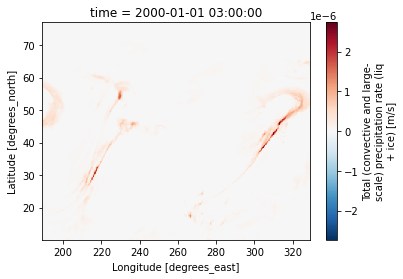

In [21]:
# high res (0.25deg)
PRECT.isel(time=0).plot();

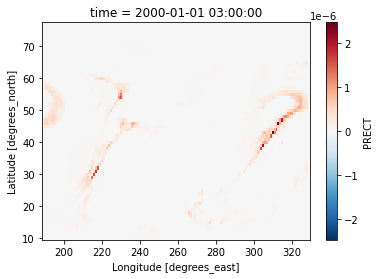

In [22]:
# low res (1deg)
PRECT_1deg.isel(time=0).plot();

### Save out regional, concatenated, regridded file to prevent Dask memory issues

In [23]:
PRECT_1deg.to_netcdf(cesm_rcp26_filepath+'PRECT_1deg.nc', mode='w', format='NETCDF4')

### Read back in intermediate file

This time, include lat/lon chunks to help with quantile calculation

In [24]:
%%time
PRECT_1deg_int = xr.open_dataarray(cesm_rcp26_filepath+'PRECT_1deg.nc', chunks={'time':600, 'lat':10, 'lon':20})
PRECT_1deg_int

CPU times: user 181 ms, sys: 3.96 ms, total: 185 ms
Wall time: 224 ms


,Array,Chunk
Bytes,3.34 GiB,0.92 MiB
Shape,"(46720, 68, 141)","(600, 10, 20)"
Count,4369 Tasks,4368 Chunks
Type,float64,numpy.ndarray


### Calculate 90th percentile precipitation at each gridpoint

In [25]:
%%time
p90 = PRECT_1deg_int.chunk({'time': -1}).quantile(0.9, dim='time')
#p90 = PRECT_1deg_int.quantile(0.9, dim='time') # cannot be chunked in time to calculate quantiles

CPU times: user 21.9 ms, sys: 969 µs, total: 22.8 ms
Wall time: 44.1 ms


In [26]:
p90

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<getitem, shape=(68, 141), dtype=float64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

### Select gridpoints where precipitation at a given time is greater than p90

In [27]:
%%time
PEx = PRECT_1deg_int.where(PRECT_1deg_int > p90)

CPU times: user 38.2 ms, sys: 0 ns, total: 38.2 ms
Wall time: 56.1 ms


In [28]:
PEx

,Array,Chunk
Bytes,3.34 GiB,0.92 MiB
Shape,"(46720, 68, 141)","(600, 10, 20)"
Count,13553 Tasks,4368 Chunks
Type,float64,numpy.ndarray


CPU times: user 3.44 s, sys: 119 ms, total: 3.56 s
Wall time: 11.2 s


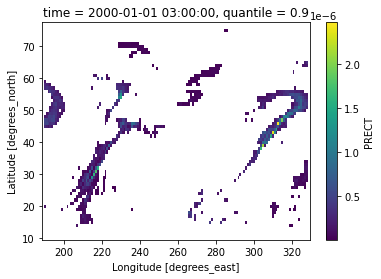

In [29]:
%%time
PEx.isel(time=0).plot();

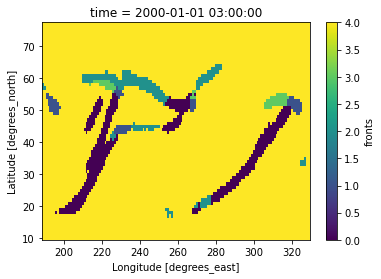

In [30]:
# fronts at the same time index
allfronts.isel(time=0).plot();

### Make a front mask (any/none)

In [31]:
%%time
anyfront = allfronts.where(allfronts < 4)

CPU times: user 21.6 ms, sys: 1.96 ms, total: 23.6 ms
Wall time: 26.8 ms


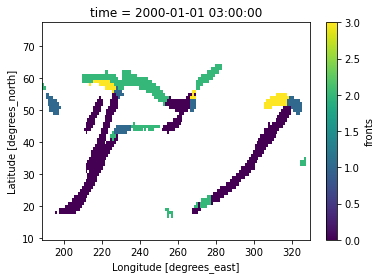

In [32]:
anyfront.isel(time=0).plot();

### Find gridpoints that overlap (front & PEx)

In [33]:
%%time
PEx_front = PEx.where(anyfront.notnull())

CPU times: user 166 ms, sys: 832 µs, total: 167 ms
Wall time: 171 ms


In [34]:
PEx_front

,Array,Chunk
Bytes,3.34 GiB,562.50 kiB
Shape,"(46720, 68, 141)","(360, 10, 20)"
Count,65554 Tasks,10192 Chunks
Type,float64,numpy.ndarray


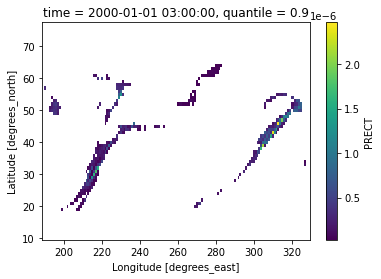

In [35]:
# PEx associated with fronts (overlapping gridpoints)
PEx_front.isel(time=0).plot();

### Percent gridpoints that overlap

In [65]:
ngridpoints = PEx_front.lat.count() * PEx_front.lon.count()

In [66]:
ngridpoints.values

array(9588)

In [39]:
overlap = PEx_front.notnull().sum(dim=('lat','lon'))

In [40]:
overlap

<xarray.DataArray 'PRECT' (time: 46720)>
dask.array<sum-aggregate, shape=(46720,), dtype=int64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [69]:
%%time
noverlap = overlap.values

CPU times: user 24.1 s, sys: 511 ms, total: 24.7 s
Wall time: 28.1 s


In [70]:
npercent = 100*(noverlap/ngridpoints.values)
npercent

array([4.19274093, 4.20317063, 4.07801418, ..., 2.7534418 , 2.32582395,
       2.24238632])

In [71]:
len(npercent)

46720

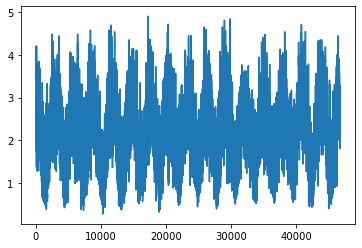

In [72]:
plt.plot(npercent);

In [73]:
# convert this back into a data array
npercent = xr.DataArray(npercent, dims=overlap.dims, coords=overlap.coords)
npercent

<xarray.DataArray (time: 46720)>
array([4.19274093, 4.20317063, 4.07801418, ..., 2.7534418 , 2.32582395,
       2.24238632])
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

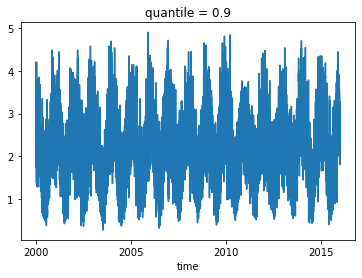

In [74]:
# plot with nicer time axis
npercent.plot();

### Percent gridpoints that overlap, relative to PEx gridpoints (instead of total)

In [36]:
PExgridpoints = PEx.notnull().sum(dim=('lat','lon'))

In [37]:
PExgridpoints

<xarray.DataArray 'PRECT' (time: 46720)>
dask.array<sum-aggregate, shape=(46720,), dtype=int64, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [41]:
npercentPEx = 100*(overlap/PExgridpoints)

In [42]:
npercentPEx

<xarray.DataArray 'PRECT' (time: 46720)>
dask.array<mul, shape=(46720,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

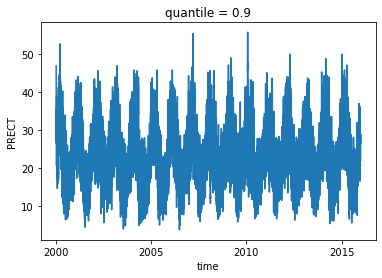

In [79]:
npercentPEx.plot();

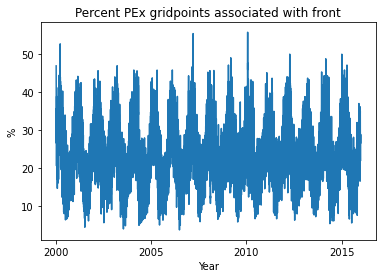

In [43]:
plt.plot(npercentPEx.time, npercentPEx)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front');
#plt.savefig('npercentPEx_2000-2005.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_2000-2015.png', bbox_inches='tight')

### Percent gridpoints that overlap, looking over time instead of space

In [44]:
overlap_time = PEx_front.notnull().sum(dim='time')
overlap_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sum-aggregate, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

In [45]:
PExgridpoints_time = PEx.notnull().sum(dim='time')
PExgridpoints_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<sum-aggregate, shape=(68, 141), dtype=int64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

In [46]:
npercentPEx_time = 100*(overlap_time/PExgridpoints_time)
npercentPEx_time

<xarray.DataArray 'PRECT' (lat: 68, lon: 141)>
dask.array<mul, shape=(68, 141), dtype=float64, chunksize=(10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * lat       (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
    quantile  float64 0.9

CPU times: user 26.1 s, sys: 489 ms, total: 26.6 s
Wall time: 35.5 s


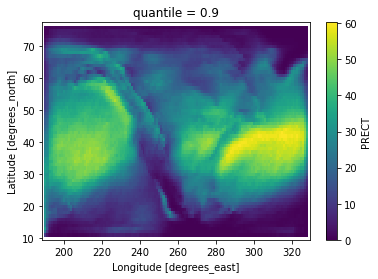

In [47]:
%%time
npercentPEx_time.plot();

A nicer plot

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


CPU times: user 32.4 s, sys: 601 ms, total: 33 s
Wall time: 48.2 s


Text(0.5, 1.0, 'Percent PEx gridpoints associated with front, 2000-2015')

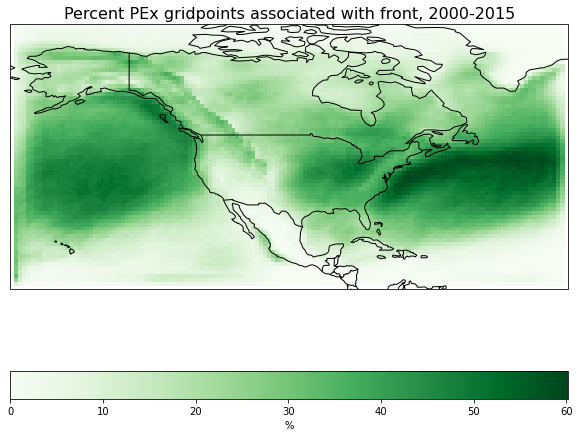

In [48]:
%%time
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

field, lon = add_cyclic_point(npercentPEx_time, coord=npercentPEx_time.lon)
lat = npercentPEx_time.lat
#cf = ax.contourf(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())
cf = ax.pcolor(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())

# add colorbar
cbar = plt.colorbar(cf, orientation='horizontal')
cbar.set_label('%')

# add title
#ax.set_title('Percent PEx gridpoints associated with front, 2000-2006', fontsize=16); # note this plot has a label error (should be 2000-2005)
ax.set_title('Percent PEx gridpoints associated with front, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_2000-2005.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentPEx_time_2000-2015.png', bbox_inches='tight')

## CESM RCP8.5 simulation, 2086-2100

In [118]:
onehot_file_rcp85 = "cesm_frontsOneHot_2086-2100.nc"

In [119]:
onehot_rcp85 = xr.open_dataset(cesm_fronts_filepath+onehot_file_rcp85, chunks={'time':360}) # aim for chunk size < 100mb

In [120]:
fronts_rcp85 = onehot_rcp85.fronts

Extract most likely front from onehot (via argmax)

In [54]:
allfronts_rcp85 = fronts_rcp85.argmax(dim='front')

In [121]:
allfronts_rcp85

<xarray.DataArray 'fronts' (time: 43800, lat: 68, lon: 141)>
dask.array<nanarg_agg-aggregate, shape=(43800, 68, 141), dtype=int64, chunksize=(360, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0

### Read in precipitation field

In [56]:
cesm_rcp85_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP85C5CN/" # RCP8.5 output

In [57]:
# h5.PRECT is 3hrly instantaneous
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)
PRECT_rcp85_files = "b.e13.BRCP85C5CN.ne120_g16.003a.cam.h5.PRECT*regrid*.nc"

read in PRECT files with preprocessing function

In [87]:
%%time
PRECT_rcp85 = xr.open_mfdataset(cesm_rcp85_filepath+PRECT_rcp85_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)

CPU times: user 193 ms, sys: 12.9 ms, total: 206 ms
Wall time: 815 ms


In [88]:
PRECT_rcp85

<xarray.DataArray 'PRECT' (time: 43801, lat: 285, lon: 448)>
dask.array<concatenate, shape=(43801, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2086-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

### Get rid of last time index (year 2101)

In [89]:
PRECT_rcp85 = PRECT_rcp85[:-1,:,:] # not sure how to do this with xarray indexing
PRECT_rcp85

<xarray.DataArray 'PRECT' (time: 43800, lat: 285, lon: 448)>
dask.array<getitem, shape=(43800, 285, 448), dtype=float32, chunksize=(150, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

### Regridding precipitation output to match fronts

In [92]:
PRECT_1deg_rcp85 = regridder(PRECT_rcp85)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [93]:
PRECT_1deg_rcp85

<xarray.DataArray 'PRECT' (time: 43800, lat: 68, lon: 141)>
dask.array<transpose, shape=(43800, 68, 141), dtype=float64, chunksize=(150, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

### Save out regional, concatenated, regridded file to prevent Dask memory issues

In [94]:
PRECT_1deg_rcp85.to_netcdf(cesm_rcp85_filepath+'PRECT_1deg.nc', mode='w', format='NETCDF4')

### Read back in intermediate file

This time, include lat/lon chunks to help with quantile calculation

In [95]:
PRECT_1deg_int_rcp85 = xr.open_dataarray(cesm_rcp85_filepath+'PRECT_1deg.nc', chunks={'time':600, 'lat':10, 'lon':20})
PRECT_1deg_int_rcp85

,Array,Chunk
Bytes,3.13 GiB,0.92 MiB
Shape,"(43800, 68, 141)","(600, 10, 20)"
Count,4089 Tasks,4088 Chunks
Type,float64,numpy.ndarray


### Calculate 90th percentile precipitation at each gridpoint

In [96]:
p90_rcp85 = PRECT_1deg_int_rcp85.chunk({'time': -1}).quantile(0.9, dim='time')

### Select gridpoints where precipitation at a given time is greater than p90

In [122]:
PEx_rcp85 = PRECT_1deg_int_rcp85.where(PRECT_1deg_int_rcp85 > p90_rcp85)

CPU times: user 3.95 s, sys: 93.2 ms, total: 4.05 s
Wall time: 10.9 s


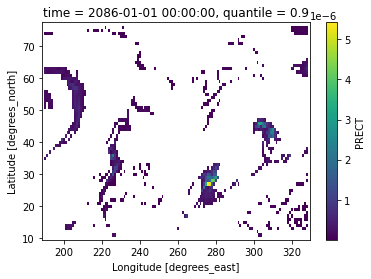

In [123]:
%%time
PEx_rcp85.isel(time=0).plot();

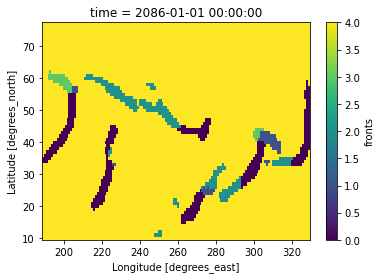

In [124]:
# fronts at the same time index
allfronts_rcp85.isel(time=0).plot();

### Make a front mask (any/none)

In [125]:
anyfront_rcp85 = allfronts_rcp85.where(allfronts_rcp85 < 4)

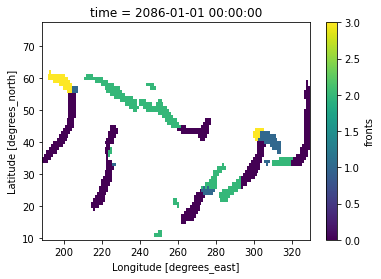

In [126]:
anyfront_rcp85.isel(time=0).plot();

### Find gridpoints that overlap (front & PEx)

In [127]:
PEx_front_rcp85 = PEx_rcp85.where(anyfront_rcp85.notnull())

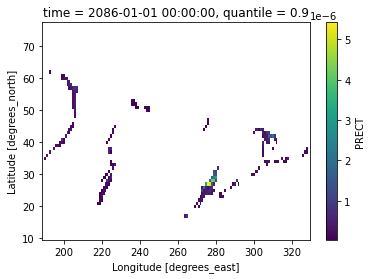

In [128]:
# PEx associated with fronts (overlapping gridpoints)
PEx_front_rcp85.isel(time=0).plot();

### Percent gridpoints that overlap, relative to PEx gridpoints (instead of total)

In [129]:
overlap_rcp85 = PEx_front_rcp85.notnull().sum(dim=('lat','lon'))

In [130]:
PExgridpoints_rcp85 = PEx_rcp85.notnull().sum(dim=('lat','lon'))

In [131]:
npercentPEx_rcp85 = 100*(overlap_rcp85/PExgridpoints_rcp85)

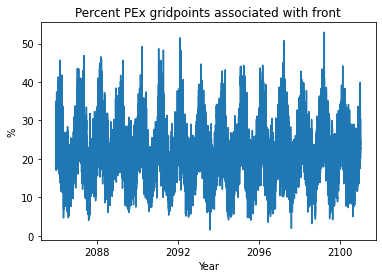

In [132]:
plt.plot(npercentPEx_rcp85.time, npercentPEx_rcp85)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front');
#plt.savefig('../figures/toSCP/npercentPEx_2086-2100.png', bbox_inches='tight')

### Percent gridpoints that overlap, looking over time instead of space

In [133]:
overlap_time_rcp85 = PEx_front_rcp85.notnull().sum(dim='time')

In [134]:
PExgridpoints_time_rcp85 = PEx_rcp85.notnull().sum(dim='time')

In [135]:
npercentPEx_time_rcp85 = 100*(overlap_time_rcp85/PExgridpoints_time_rcp85)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


CPU times: user 37.7 s, sys: 617 ms, total: 38.3 s
Wall time: 53.3 s


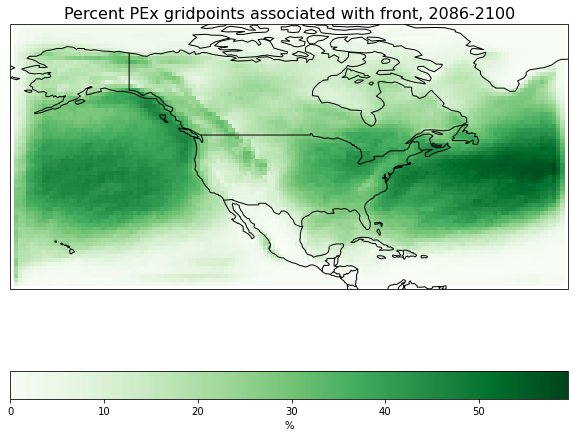

In [136]:
%%time
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

field, lon = add_cyclic_point(npercentPEx_time_rcp85, coord=npercentPEx_time_rcp85.lon)
lat = npercentPEx_time_rcp85.lat
#cf = ax.contourf(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())
cf = ax.pcolor(lon, lat, field, cmap='Greens', transform=ccrs.PlateCarree())

# add colorbar
cbar = plt.colorbar(cf, orientation='horizontal')
cbar.set_label('%')

# add title
ax.set_title('Percent PEx gridpoints associated with front, 2086-2100', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_2085-2100.png', bbox_inches='tight')

## Difference, RCP8.5 - historical/RCP2.6

### Subset historical to match # years (2000-2014)

In [146]:
npercentPEx

<xarray.DataArray 'PRECT' (time: 46720)>
dask.array<mul, shape=(46720,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    quantile  float64 0.9

In [160]:
#npercentPEx.sel(time="2000-01-01 03:00:00")
#npercentPEx.sel(time="2014-12-31 21:00:00")
#npercentPEx.sel(time=slice("2000-01-01 03:00:00", "2014-12-31 21:00:00")) # this does not work for reasons I don't understand?
npercentPEx_subset = npercentPEx[:43800] # so I have to do it the old fashioned way (just cut off the last year manually)
npercentPEx_subset

<xarray.DataArray 'PRECT' (time: 43800)>
dask.array<getitem, shape=(43800,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-01-01 03:00:00 ... 2014-12-31 21:00:00
    quantile  float64 0.9

In [139]:
npercentPEx_rcp85

<xarray.DataArray 'PRECT' (time: 43800)>
dask.array<mul, shape=(43800,), dtype=float64, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
    quantile  float64 0.9

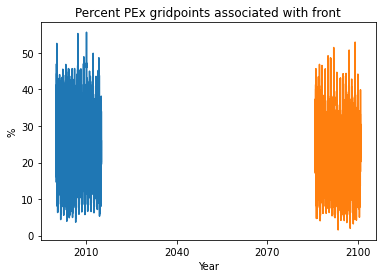

In [163]:
plt.plot(npercentPEx_subset.time, npercentPEx_subset)
plt.plot(npercentPEx_rcp85.time, npercentPEx_rcp85)
plt.xlabel('Year')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front');

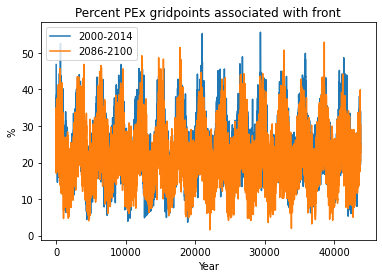

In [172]:
plt.plot(npercentPEx_subset, label='2000-2014')
plt.plot(npercentPEx_rcp85, label='2086-2100')
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Percent PEx gridpoints associated with front')
plt.legend();

In [174]:
spatialdiff = npercentPEx_time_rcp85 - npercentPEx_time

CPU times: user 1min, sys: 1.26 s, total: 1min 1s
Wall time: 1min 10s


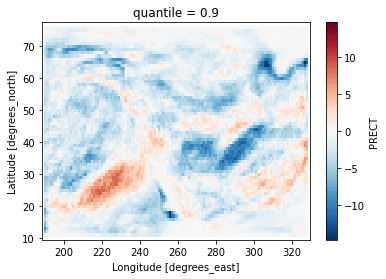

In [175]:
%%time
spatialdiff.plot();

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


CPU times: user 1min 18s, sys: 1.58 s, total: 1min 20s
Wall time: 1min 37s


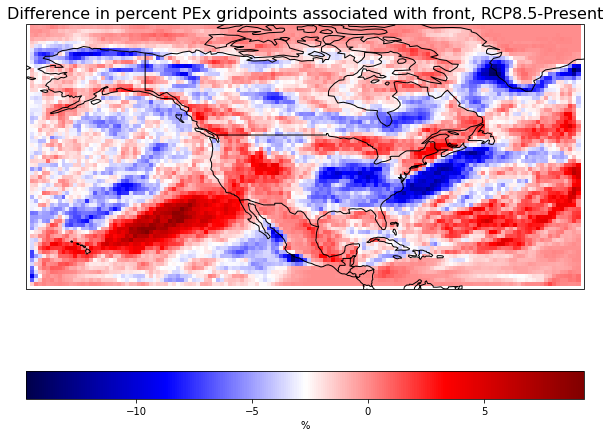

In [176]:
%%time
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

field, lon = add_cyclic_point(spatialdiff, coord=spatialdiff.lon)
lat = spatialdiff.lat
cf = ax.pcolor(lon, lat, field, cmap='seismic', transform=ccrs.PlateCarree())

# add colorbar
cbar = plt.colorbar(cf, orientation='horizontal')
cbar.set_label('%')

# add title
ax.set_title('Difference in percent PEx gridpoints associated with front, RCP8.5-Present', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentPEx_time_diff.png', bbox_inches='tight')

### TO DO: Seasonal plots?